In [204]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md

# Importing the data and initial validations

In [205]:
# Visualisations theme
sns.set_theme()

# Importing data
df = pd.read_csv('assignment_data.csv', index_col=0)

df.head()

,UserId,Event,Total,Date,Group
0,2a05f55afa6738cb5dad988372cb702c,sensor_calibrated,1,2022-05-01,baseline
1,deb636faf0ce880f84c00d5397b65e0b,sensor_calibrated,1,2022-05-01,baseline
2,96f29eaa3ee441f78b3074a4736138e5,sensor_calibrated,1,2022-05-01,baseline
3,67054448e92fed803aae6fdfda859f0a,sensor_calibrated,1,2022-05-01,baseline
4,2d4ce867dccf5af85ef52010cfe0599c,sensor_calibrated,1,2022-05-01,baseline


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40932 entries, 0 to 40931
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   UserId  40932 non-null  object
 1   Event   40932 non-null  object
 2   Total   40932 non-null  int64 
 3   Date    40932 non-null  object
 4   Group   40932 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [207]:
# Changing date format to datetime
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

# Check if there are duplicated rows
df.duplicated().sum()

0

No duplicated rows

In [208]:
# Checking that sensor calibrated is the first event
min_dates = df.groupby('UserId')['Date'].min().reset_index()
sensor_calibrated = df[df['Event']=='sensor_calibrated'].groupby('UserId')['Date'].min().reset_index()

df_check = min_dates.merge(sensor_calibrated, on='UserId', suffixes=("","_calibrated"))

df_check['validation'] = 0

# If date calibrated is after another event, then validation is 1
df_check.loc[df_check['Date_calibrated'] > df_check['Date'], 'validation'] = 1
df_check['validation'].max()

0

Sensor calibrated is always the first event

In [209]:
# Checking that users belong to only one group
df_check2 = df.groupby('UserId')['Group'].nunique().reset_index()
df_check2['Group'].max()

1

Users belong only to 1 group

In [210]:
# Checking that users have only one event of sensor calibrated
df_check3 = df.groupby(['UserId','Event'])['Total'].count().reset_index()
df_check3[df_check3['Event']=='sensor_calibrated']['Total'].max()

1

Only one sesion calibrated event

In [211]:
# Checking that users have only one register of an event per day
df_check4 = df.groupby(['UserId','Event','Date'])['Total'].count().reset_index()
df_check4['Total'].max()

1

Only one event recorded per day

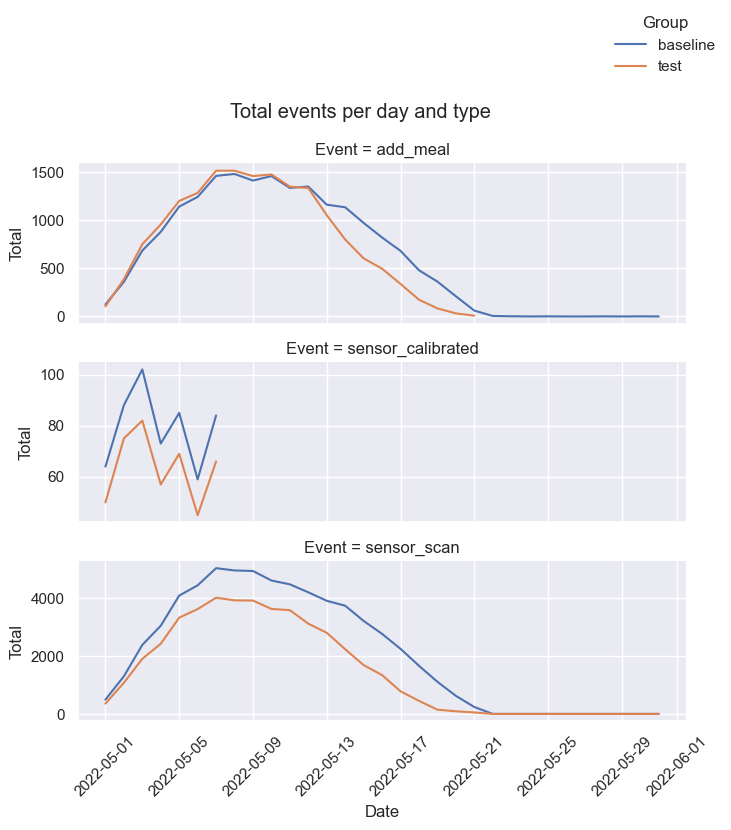

In [212]:
# Check counts of events per day
df_totals = df.groupby(['Date','Event','Group'])['Total'].sum().reset_index()

# Plotting total amount of events per day
g = sns.FacetGrid(df_totals, col='Event', hue='Group',
    col_wrap=1, sharey=False,
    height=2.5, aspect=2.5)
g.map(sns.lineplot, 'Date', 'Total')
g.add_legend()
sns.move_legend(g, loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
g.figure.suptitle('Total events per day and type')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)
g.figure.tight_layout()

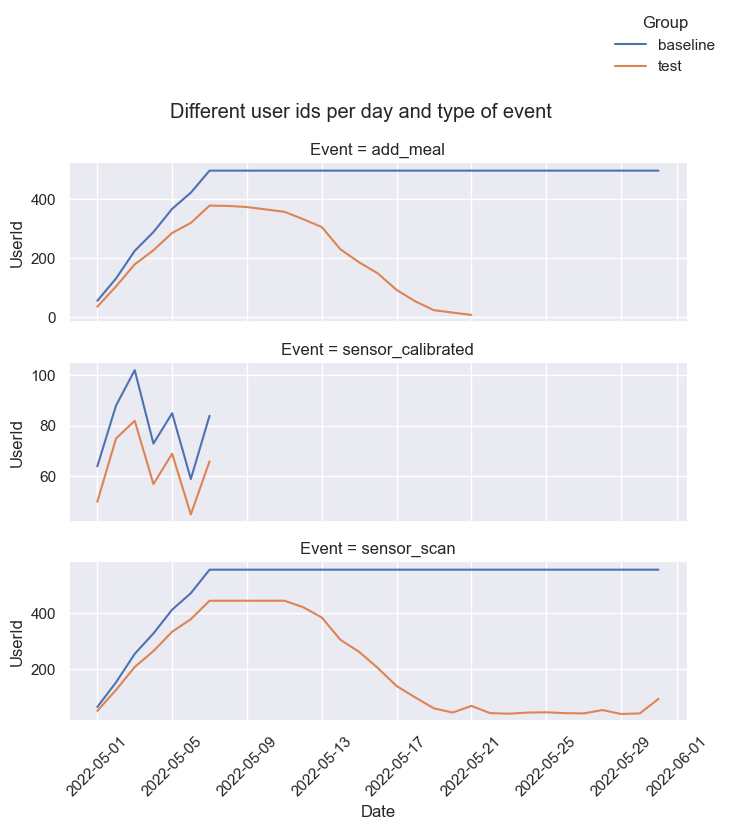

In [213]:
# Check users per event per day
df_users = df.groupby(['Date','Event','Group'])['UserId'].nunique().reset_index()

# Plotting different users per event and day
g = sns.FacetGrid(df_users, col='Event', hue='Group',
    col_wrap=1, sharey=False,
    height=2.5, aspect=2.5)
g.map(sns.lineplot, 'Date', 'UserId')
g.add_legend()
sns.move_legend(g, loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
g.figure.suptitle('Different user ids per day and type of event')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)
g.figure.tight_layout()

As the time passes the amount of users scaning and adding meals drops for the test group, for the baseline we have the same amount of users during the full period.

It indicates 2 different effects:
- Usage of the scans and adding meals drops with time, there is a user retention drop.
- Data quality is different between groups, not all the users from the test are reported if their amounts are 0

In order to process the data we will need to remove users with registers of value 0, to make the groups comparable

In [214]:
df_clean = df[df['Total']>0]

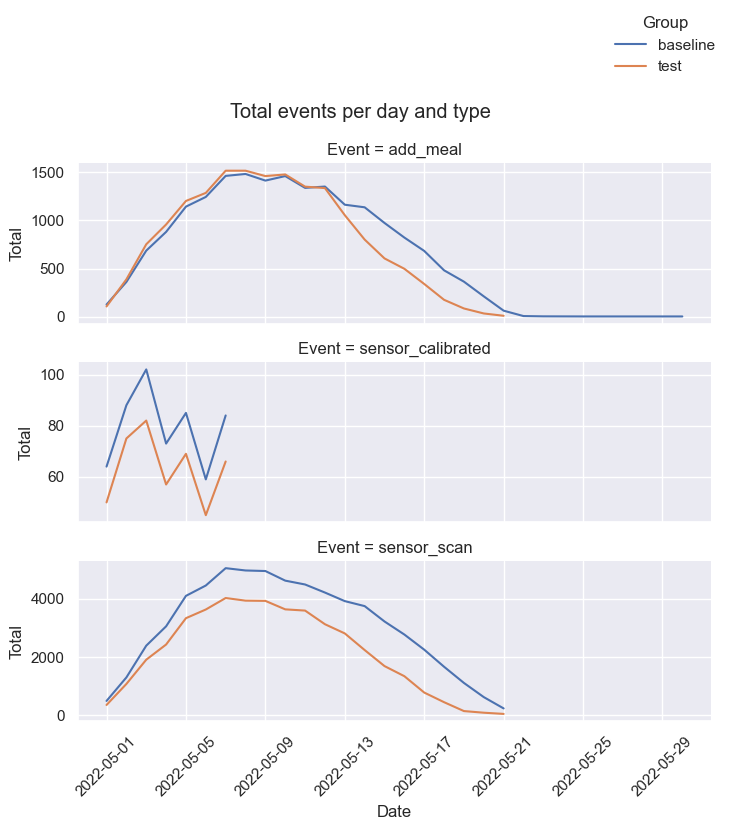

In [215]:
# Check counts of events per day
df_totals_clean = df_clean.groupby(['Date','Event','Group'])['Total'].sum().reset_index()

# Plotting total amount of events per day
g = sns.FacetGrid(df_totals_clean, col='Event', hue='Group',
    col_wrap=1, sharey=False,
    height=2.5, aspect=2.5)
g.map(sns.lineplot, 'Date', 'Total')
g.add_legend()
sns.move_legend(g, loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
g.figure.suptitle('Total events per day and type')
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)
g.figure.tight_layout()

There shouldn't be any meals added without a sensor scan, so we will also need to clean those cases from the data frame. In particular considering their low value they are most likely reporting errors on the data.

In [216]:
df_clean['Date'].max()

Timestamp('2022-05-30 00:00:00')

In [217]:
# Maximum date for valid data
df_clean[df_clean['Event']=='sensor_scan']['Date'].max()

Timestamp('2022-05-21 00:00:00')

In [218]:
# Limit dates for analysis
df_clean = df_clean[df_clean['Date']<='2022-05-21']
df_clean['Date'].max()

Timestamp('2022-05-21 00:00:00')

# Preparation of data frame for analysis

In [219]:
# Generating data frames for analysis
df_start = df_clean[df_clean['Event']=='sensor_calibrated']
df_events = df_clean[df_clean['Event']!='sensor_calibrated']

# Transforming events rows to columns
df_events = df_events.pivot_table(index=['UserId','Date','Group'], columns='Event', values='Total').reset_index()
df_events.head()

Event,UserId,Date,Group,add_meal,sensor_scan
0,00065f61688bf266d956b14d1efa0d07,2022-05-07,test,2.0,22.0
1,00065f61688bf266d956b14d1efa0d07,2022-05-08,test,2.0,12.0
2,00065f61688bf266d956b14d1efa0d07,2022-05-09,test,1.0,6.0
3,00065f61688bf266d956b14d1efa0d07,2022-05-10,test,4.0,4.0
4,00065f61688bf266d956b14d1efa0d07,2022-05-11,test,1.0,4.0


In [220]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11975 entries, 0 to 11974
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UserId       11975 non-null  object        
 1   Date         11975 non-null  datetime64[ns]
 2   Group        11975 non-null  object        
 3   add_meal     8757 non-null   float64       
 4   sensor_scan  11951 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 467.9+ KB


In [221]:
df_events.describe()

Event,add_meal,sensor_scan
count,8757.000000,11951.000000
mean,4.088843,9.038491
std,2.716691,9.065454
min,1.000000,1.000000
25%,2.000000,4.000000
50%,4.000000,7.000000
75%,5.000000,11.000000
max,28.000000,122.000000


It seems unreasonable to have a user that has added 28 meals in one day and that has added 122 sensor scans, so we will cap based on 95 percentile

In [222]:
# Calculating caps
add_meal_cap = df_events['add_meal'].quantile(0.95)
sensor_scan_cap = df_events['sensor_scan'].quantile(0.95)
print('add_meal cap:', add_meal_cap)
print('sensor_scan cap:', sensor_scan_cap)

# Replacing caps
df_events.loc[df_events['add_meal']>add_meal_cap,'add_meal'] = add_meal_cap
df_events.loc[df_events['sensor_scan']>sensor_scan_cap,'sensor_scan'] = sensor_scan_cap

df_events.describe()

add_meal cap: 9.0
sensor_scan cap: 24.0


Event,add_meal,sensor_scan
count,8757.000000,11951.000000
mean,3.956149,8.324408
std,2.314452,5.986018
min,1.000000,1.000000
25%,2.000000,4.000000
50%,4.000000,7.000000
75%,5.000000,11.000000
max,9.000000,24.000000


In [223]:
# Checking for added meals without sensor scan
df_events[df_events['sensor_scan'].isna()]['add_meal'].count()

24

As discussed earlier we will consider this registers as invalid and we will remove them

In [224]:
# Checking for added meals NaN but with sensor scan
df_events[df_events['add_meal'].isna()]['sensor_scan'].count()

3218

These registers are valid, the user was present and having a sensor scan but didn't register any meals. We will convert them in 0 instead

In [225]:
# Filling NaN added meals with 0
df_events['add_meal'].fillna(0, inplace=True)

# Removing rowns with NaN in sensor scan
df_events = df_events[df_events['sensor_scan'].notna()].reset_index(drop=True)


In [226]:
df_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11951 entries, 0 to 11950
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   UserId       11951 non-null  object        
 1   Date         11951 non-null  datetime64[ns]
 2   Group        11951 non-null  object        
 3   add_meal     11951 non-null  float64       
 4   sensor_scan  11951 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 467.0+ KB


In [227]:
df_events.describe()

Event,add_meal,sensor_scan
count,11951.000000,11951.000000
mean,2.896327,8.324408
std,2.645855,5.986018
min,0.000000,1.000000
25%,0.000000,4.000000
50%,3.000000,7.000000
75%,5.000000,11.000000
max,9.000000,24.000000


It could be that some users have gaps on their dates, so we need to make sure to fill those 

In [228]:
# Checking differences in dates
dates_user = df_events.groupby('UserId')['Date'].nunique()
print(dates_user.max(), dates_user.min())

# Checking min and max dates using also sensor scan events
date_start = df_start['Date'].min()
date_end = df_events['Date'].max()

16 1


In [229]:
# Joining users with all potential dates
dates = pd.DataFrame(pd.date_range(start=date_start, end=date_end, freq='D'), columns=['Date'])
users = pd.DataFrame(df_events['UserId'].unique(), columns=['UserId'])
df_fill = users.merge(dates, how='cross').reset_index(drop=True)
df_fill.head()

,UserId,Date
0,00065f61688bf266d956b14d1efa0d07,2022-05-01
1,00065f61688bf266d956b14d1efa0d07,2022-05-02
2,00065f61688bf266d956b14d1efa0d07,2022-05-03
3,00065f61688bf266d956b14d1efa0d07,2022-05-04
4,00065f61688bf266d956b14d1efa0d07,2022-05-05


In [230]:
# Checking that all dates are present for this dataframe
dates_user_fill = df_fill.groupby('UserId')['Date'].nunique()
print(dates_user_fill.max(), dates_user_fill.min())

21 21


In [231]:
# Merging data frames with all possible dates
df_events = df_fill.merge(df_events, how='outer', on=['UserId','Date'], suffixes=("","_fill")).reset_index(drop=True)

# Merging with start date and dropping unnecesary columns
df_analysis = df_events.merge(df_start, on='UserId', suffixes=("","_start")).drop(['Event', 'Total'], axis=1)
df_analysis['Group'] = df_analysis['Group_start']
df_analysis.drop(['Group_start'], axis=1, inplace=True)

# Keeping only Dates that are higher than Date_start
df_analysis = df_analysis[df_analysis['Date']>=df_analysis['Date_start']].reset_index(drop=True)

# Filling NaN with 0
df_analysis['add_meal'].fillna(0, inplace=True)
df_analysis['sensor_scan'].fillna(0, inplace=True)

# Adding column for days since sensor calibrated
df_analysis['Days'] = (df_analysis['Date'] - df_analysis['Date_start']).dt.days

# Adding column for retention
df_analysis['Retention'] = 0
df_analysis.loc[df_analysis['sensor_scan']>0,'Retention'] = 1

df_analysis.head()


,UserId,Date,Group,add_meal,sensor_scan,Date_start,Days,Retention
0,00065f61688bf266d956b14d1efa0d07,2022-05-07,test,2.0,22.0,2022-05-07,0,1
1,00065f61688bf266d956b14d1efa0d07,2022-05-08,test,2.0,12.0,2022-05-07,1,1
2,00065f61688bf266d956b14d1efa0d07,2022-05-09,test,1.0,6.0,2022-05-07,2,1
3,00065f61688bf266d956b14d1efa0d07,2022-05-10,test,4.0,4.0,2022-05-07,3,1
4,00065f61688bf266d956b14d1efa0d07,2022-05-11,test,1.0,4.0,2022-05-07,4,1


In [232]:
# Checking differences in dates after modifications
dates_user = df_analysis.groupby('UserId')['Date'].nunique()
print(dates_user.max(), dates_user.min())

21 15


# Analysis of the AB test

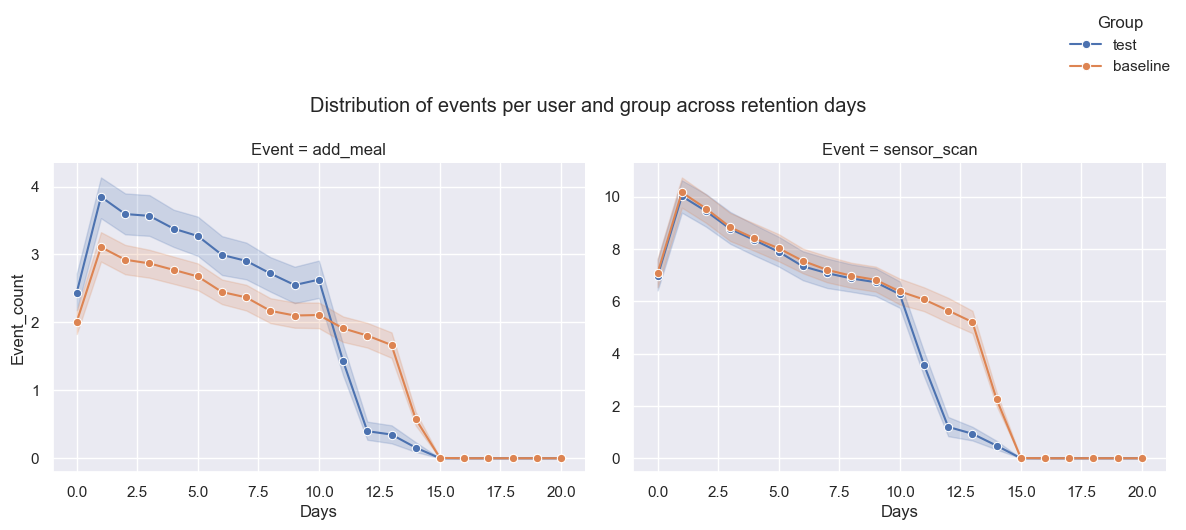

In [233]:
# Formatting dataframe for FaceGrid
df_plot_daily = df_analysis.melt(id_vars=['UserId','Date','Group','Date_start','Days','Retention'],
                                 value_vars=['add_meal','sensor_scan'],var_name='Event',value_name='Event_count')

# Plotting total amount of events per day
g = sns.FacetGrid(df_plot_daily, col='Event', hue='Group',
    col_wrap=2, sharey=False,
    height=4.5, aspect=1.2)
g.map(sns.lineplot, 'Days', 'Event_count',  marker='o')
g.add_legend()
sns.move_legend(g, loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
g.figure.suptitle('Distribution of events per user and group across retention days')
g.figure.tight_layout()

Text(0.5, 1.0, 'Retention per day')

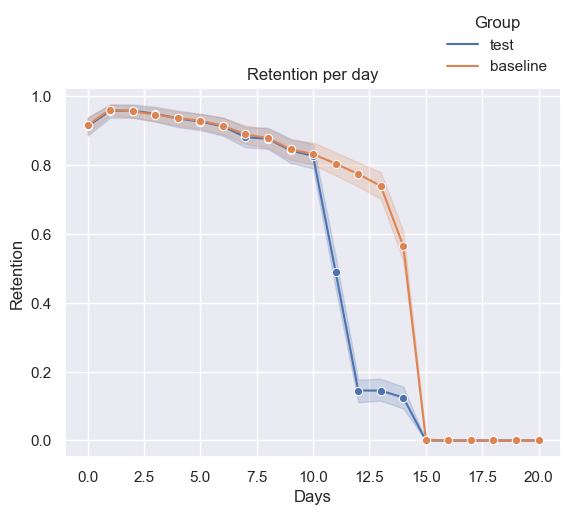

In [235]:
g = sns.lineplot(x='Days', y='Retention', hue='Group', data=df_analysis, marker='o')
sns.move_legend(g, loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
g.set_title('Retention per day')

We can observe that the numbers of added meals is higher for the test group, however it is interesting to investigate why the retention considerably drops for the test group.

The assumption for this excercise would be that the test was stopped beforehand over the test group. Otherwise, it requires to be investigated in more depth.

We can also see that the test contributes significantly to the uplift in added meals, the high density interval from the bootstrap of means doesn't overlap until day 10 from the start of the test (sensor calibrated).

To get rid of that effect we will only consider the test until day 10 of retention for the upcoming analyses

In [236]:
# Creating dataframe for total agregated metrics capping until retention day 10
df_users = df_analysis.groupby(['UserId','Group']).apply(lambda x: pd.Series(dict(
                                                              total_meals=(x.loc[x['Days'] <= 10, 'add_meal']).sum(),
                                                              total_scans=(x.loc[x['Days'] <= 10, 'sensor_scan']).sum(),
                                                              d0_meals=(x.loc[x['Days'] <= 0, 'add_meal']).sum(),
                                                              d0_scans=(x.loc[x['Days'] <= 0, 'sensor_scan']).sum(),
                                                              d1_meals=(x.loc[x['Days'] <= 1, 'add_meal']).sum(),
                                                              d1_scans=(x.loc[x['Days'] <= 1, 'sensor_scan']).sum(),
                                                              d3_meals=(x.loc[x['Days'] <= 3, 'add_meal']).sum(),
                                                              d3_scans=(x.loc[x['Days'] <= 3, 'sensor_scan']).sum(),
                                                              d7_meals=(x.loc[x['Days'] <= 7, 'add_meal']).sum(),
                                                              d7_scans=(x.loc[x['Days'] <= 7, 'sensor_scan']).sum(),
                                                              d1_ret=(x.loc[x['Days'] == 1, 'Retention']).max(),
                                                              d3_ret=(x.loc[x['Days'] == 3, 'Retention']).max(),
                                                              d7_ret=(x.loc[x['Days'] == 7, 'Retention']).max()
                                                              ))).reset_index()
df_users.head()

,UserId,Group,total_meals,total_scans,d0_meals,d0_scans,d1_meals,d1_scans,d3_meals,d3_scans,d7_meals,d7_scans,d1_ret,d3_ret,d7_ret
0,00065f61688bf266d956b14d1efa0d07,test,23.0,77.0,2.0,22.0,4.0,34.0,9.0,44.0,20.0,61.0,1.0,1.0,1.0
1,002f4e1904eb243ebaf86ff7a6f3bc2e,baseline,55.0,63.0,2.0,1.0,10.0,8.0,21.0,24.0,40.0,49.0,1.0,1.0,1.0
2,0070954f6497eeae1f651fd73880f324,baseline,6.0,33.0,2.0,4.0,3.0,8.0,4.0,16.0,6.0,33.0,1.0,1.0,0.0
3,00b69e2db6f9de98e5accf8498a4bb6a,baseline,0.0,9.0,0.0,2.0,0.0,3.0,0.0,5.0,0.0,7.0,1.0,1.0,0.0
4,015c45161a6ea93eea54a1c8d799c9e7,test,0.0,66.0,0.0,3.0,0.0,9.0,0.0,24.0,0.0,49.0,1.0,1.0,1.0


In [237]:
# Generating summary table
columns = df_users.columns.drop('UserId')
df_summary_count = df_users.groupby('Group')['UserId'].count().to_frame()
df_summary_metrics = df_users.groupby('Group')[columns].agg(np.mean)
df_summary = df_summary_count.join(df_summary_metrics, on='Group').T.stack().unstack()
df_summary['diff_abs'] = df_summary['test'] - df_summary['baseline']
df_summary['diff_perc'] = df_summary['test']/df_summary['baseline'] - 1
df_summary.style.format('{:,.2f}')

Group,baseline,test,diff_abs,diff_perc
UserId,555.00,442.00,-113.00,-0.20
total_meals,27.55,33.90,6.35,0.23
total_scans,86.93,85.68,-1.25,-0.01
d0_meals,2.01,2.44,0.43,0.21
d0_scans,7.07,6.97,-0.10,-0.01
d1_meals,5.12,6.29,1.17,0.23
d1_scans,17.23,16.99,-0.25,-0.01
d3_meals,10.91,13.45,2.54,0.23
d3_scans,35.60,35.19,-0.41,-0.01
d7_meals,21.17,26.00,4.83,0.23


The baseline has more users than the test, indicating that the split wasn't completely 50% and 50%. However we can identify that in average the total meals scanned are ~6 more for the test group. Let's calculate some additional statistics.

In [238]:
# Helper variables
binary = ['d1_ret', 'd3_ret', 'd7_ret']
continuous = columns.drop(binary + ['Group'])

# Calculating p values for each metric based on Welch T-test
groups = df_users['Group'].unique()
p_values = pd.DataFrame(columns=continuous)
for column in continuous:
    for i in np.arange(1,len(groups)):
        p_values.loc[i, column] = stats.ttest_ind(df_users.loc[df_users['Group']==groups[0], column],
                                                  df_users.loc[df_users['Group']==groups[1], column],
                                                  nan_policy='omit', equal_var=False).pvalue

p_values

,total_meals,total_scans,d0_meals,d0_scans,d1_meals,d1_scans,d3_meals,d3_scans,d7_meals,d7_scans
1,0.00003,0.733537,0.00686,0.811361,0.000112,0.74601,0.000021,0.781246,0.000022,0.731209


We can also observe that the means difference are statistically significant between groups for total meals in the different days since sensor calibration as we saw earlier but using a different method for significance. Also previously we didn't analyse the cumulative sum until the retention day. We won't make the calculations for retention given that we know we cannot infer mean difference until retention day 10.

In [239]:
# We will create a couple of functions for bootstrapping

# Sampling with replacement with a lenght of the size of the original array
def bootstrap_rep_1d(data, func):
    bs_sample = np.random.choice(data,len(data))
    return func(bs_sample)

# Generating size amount of arrays
def bs_reps(data, func, size=1):
    bs_rep = np.empty(size)
    for i in range(size):
        bs_rep[i] = bootstrap_rep_1d(data, func)
        
    return bs_rep

# Generating dataframe with bootstrapped values of the means of 10000 different sample arrays
def bootstrap_df(df: pd.DataFrame, columns: list, variants: list) -> pd.DataFrame:
    """ Creates dataframe of bootstrapped means"""
    bs_col = {}
    for column in columns:
        bs_var = {}
        for variant in variants:
            bs_var[variant] = bs_reps(df.loc[df['Group']==variant, column],
                                      np.mean, 10000)
        bs_col[column] = bs_var
    
    bs_df = pd.DataFrame(bs_col).stack().explode().reset_index()
    bs_df = bs_df.rename(columns={'level_0': 'variant', 'level_1': 'metric', 0: 'value'})
    return bs_df

In [263]:
# Generating bootstrapped dataframe for each continuous metric
df_bs = bootstrap_df(df_users, continuous, groups)
df_bs.head()

,variant,metric,value
0,test,total_meals,31.843891
1,test,total_meals,33.011312
2,test,total_meals,34.038462
3,test,total_meals,32.687783
4,test,total_meals,31.282805


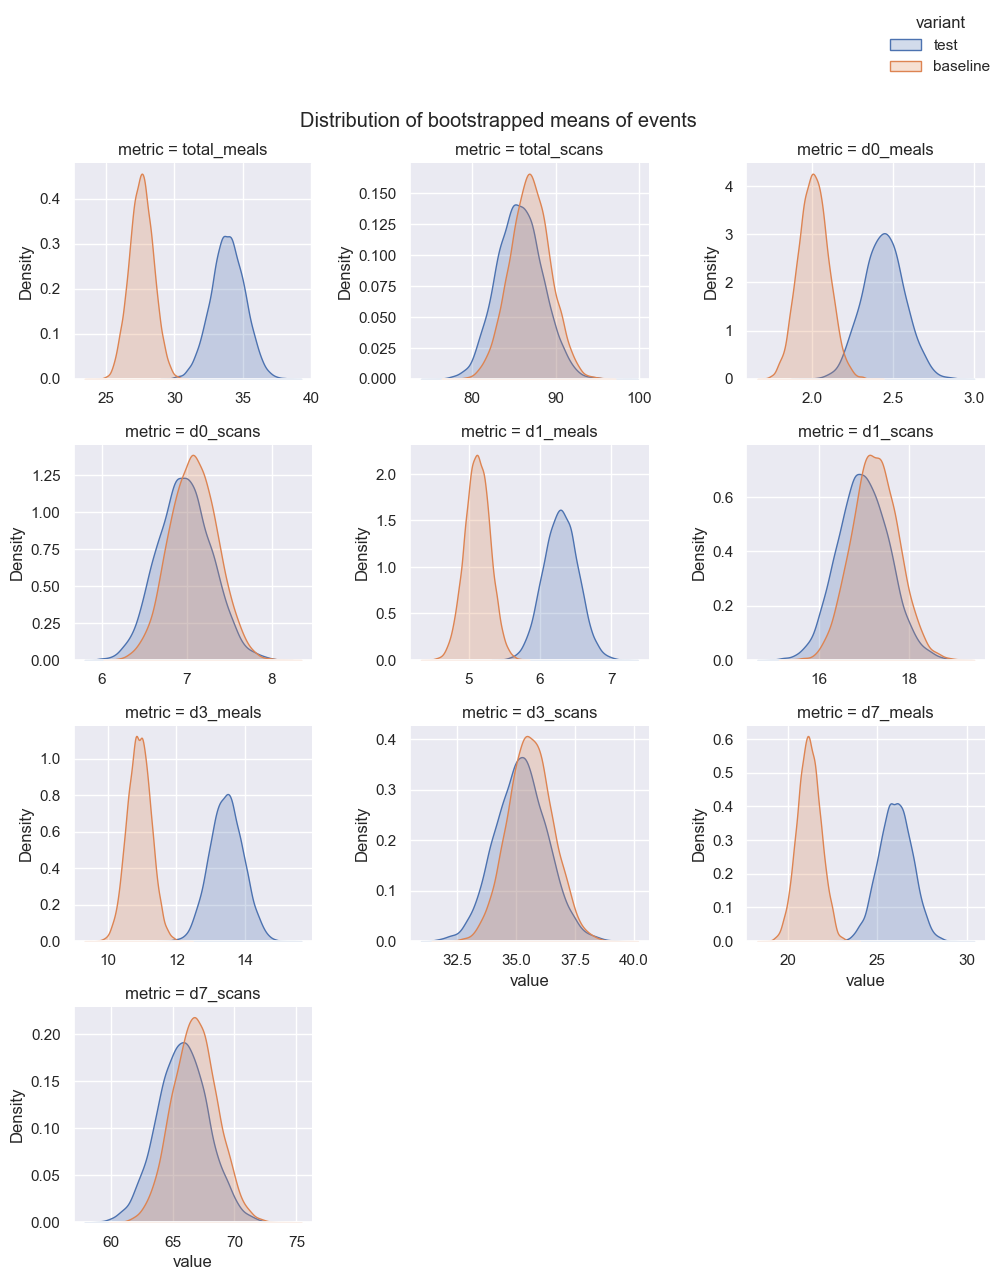

In [267]:
# Bootstrap density plot
g = sns.FacetGrid(df_bs, col='metric', hue='variant', sharex=False, sharey=False, col_wrap=3)
g.map(sns.kdeplot, 'value', fill=True)
g.add_legend()
sns.move_legend(g, loc='lower right', bbox_to_anchor=(1, 1), frameon=False)
g.figure.suptitle('Distribution of bootstrapped means of events')
g.figure.tight_layout()

From plotting the distribution of means for different samples we can also observe a significant difference between the added meals in the test in comparison to the baseline group.

In [268]:
test_upper = df_bs[(df_bs['variant']=='test') & (df_bs['metric']=='total_meals')]['value'].quantile(0.95)
test_lower = df_bs[(df_bs['variant']=='test') & (df_bs['metric']=='total_meals')]['value'].quantile(0.05)
baseline_upper = df_bs[(df_bs['variant']=='baseline') & (df_bs['metric']=='total_meals')]['value'].quantile(0.95)
baseline_lower = df_bs[(df_bs['variant']=='baseline') & (df_bs['metric']=='total_meals')]['value'].quantile(0.05)
print(f'Test: hdi [{test_lower}, {test_upper}]')
print(f'Baseline: hdi [{baseline_lower}, {baseline_upper}]')

Test: hdi [31.859615384615385, 35.923190045248866]
Baseline: hdi [26.117117117117118, 29.014504504504504]


We can also observe that the true value of the mean (90% high density interval), doesn't overlap. Confirming that the test was succesful and should be rolled out if doesn't add a considerably additional cost of implementation and if the issue with retention after day 10 has a clear explanation that doesn't affect negatively.

# Conclusions
- The test group added more meals in total, in average over a 10 day period 6 more meals were added
- The difference to the baseline group is significant. The true mean for the baseline is between 26 and 29 meals, while for the test is between 31 and 36 meals with a 90% chance
- The differences are noticeable since the initial day and at least 0.5 more meals are added per day in the test group
- There was no significant change in the amount of scans or on the retention (at least one scan on the day). However is worth noticing a drop in the retention after the 10 day for the test group. If this doesn't have a clear explanation, it needs to be investigated.
- If the retention issue is real, the bug for the new sensor after day 10 needs to be fixed before rolling it out to all users. If not, then the new sensor can be rolled out to all users considering the success in adding more meals

# Assumptions
- Meals reported without a sensor scan are not valid
- Users need to scan at least once a day to register meals
- The test has valid information only until the 21st of May 2022
- After 10 days in the experiment the information about added meals and scans is not valid
- Cases with more than 9 added meals and 24 sensor scans are capped. The 95th percentile was considered for this but with more awarness of the sensor a better cap could be used. At least from an intuitive stand point an extreme case with 9 meals per day sounds reasonable if a user adds also all the snacks consumed.